In [5]:
import torch
import torch.nn as nn
import random
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros import SuperMarioBrosEnv
from tqdm import tqdm
import pickle 
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import time
import datetime
import json
from toolkit.gym_env import *
from toolkit.action_utils import *
from toolkit.marlios_model import *
from toolkit.constants import *
import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [6]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    display(plt.gcf(), clear=True)

def make_env(env, actions=ACTION_SPACE):
    env = MaxAndSkipEnv(env, skip=2) # I am testing out fewer fram repetitions for our two actions modelling
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, actions)

def generate_epoch_time_id():
    epoch_time = int(time.time())
    return str(epoch_time)

def save_checkpoint(agent, total_rewards, terminal_info, run_id):
    with open(f"ending_position-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.ending_position, f)
    with open(f"num_in_queue-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.num_in_queue, f)
    with open(f"total_rewards-{run_id}.pkl", "wb") as f:
        pickle.dump(total_rewards, f)
    with open(f"terminal_info-{run_id}.pkl", "wb") as f:
        pickle.dump(terminal_info, f)
    if agent.double_dq:
        torch.save(agent.local_net.state_dict(), f"dq1-{run_id}.pt")
        torch.save(agent.target_net.state_dict(), f"dq2-{run_id}.pt")
    else:
        torch.save(agent.dqn.state_dict(), f"dq-{run_id}.pt")  

def load_rewards(from_file):
     with open(from_file, 'rb') as f:
        total_rewards = pickle.load(f)
        return total_rewards

def plot_rewards(ep_per_stat = 100, total_rewards = [], from_file = None):
    if from_file != None:
        total_rewards = load_rewards(total_rewards)
       
    avg_rewards = [np.mean(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]
    std_rewards = [np.std(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]

    fig, ax = plt.subplots()
    ax.plot(avg_rewards, label='Average Rewards')
    ax.fill_between(range(len(avg_rewards)), np.subtract(avg_rewards, std_rewards), np.add(avg_rewards, std_rewards), alpha=0.2, label='Reward StdDev')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    xtick_labels = [str(i*ep_per_stat) for i in range(len(avg_rewards))]
    plt.xticks(range(1, len(avg_rewards)+1), xtick_labels)
    plt.xticks(rotation=45)
    ax.legend(loc='lower right')
    plt.show()

In [7]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=6, stride=2),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 32, kernel_size=4, stride=1),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 12, kernel_size=4, stride=1),
            nn.BatchNorm2d(12),
            nn.LeakyReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        # takes the output of the convolutions and gets vector to size 32
        self.conv_to_32 = nn.Sequential(
            nn.Linear(conv_out_size, 32),
            nn.LeakyReLU()
        )

        action_size = 10

        self.action_fc = nn.Sequential(
            nn.Linear(action_size, 32),
            nn.LeakyReLU(),
        )
        
        # We take a vector of 5 being the initial action, and 5 being the second action for action size of 10
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32), # added a new layer can play with the parameters
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x, sampled_actions):
        '''
        x - image being passed in as the state
        sampled_actions - np.array with n x 8 
        '''
        big_conv_out = self.conv(x).view(x.size()[0], -1)
        conv_out = self.conv_to_32(big_conv_out)

        batched_conv_out = conv_out.reshape(conv_out.shape[0], 1, conv_out.shape[-1]).repeat(1, sampled_actions.shape[-2], 1)

        latent_actions = self.action_fc(sampled_actions)

        batched_actions = torch.cat((batched_conv_out, latent_actions), dim=2)

        out =  torch.flatten(self.fc(batched_actions), start_dim=1)

        return out

mario_env='SuperMarioBros-1-1-v0'
env = gym.make(mario_env)
env = make_env(env, ACTION_SPACE)


# observation_space = env.observation_space.shape # not using this anymore
state_space=env.observation_space.shape
#todo: add agent params as a setting/create different agents in diff functions to run 
local_net = DQNSolver(state_space)

state = env.reset()
state = torch.tensor([state])

sampled_actions = torch.from_numpy(sample_actions(TWO_ACTIONS_SET, 10)).to(torch.float32).unsqueeze(0) 


print(local_net(state, sampled_actions))

tensor([[0.1261, 0.0900, 0.1096, 0.1004, 0.1290, 0.0894, 0.1128, 0.0762, 0.1185,
         0.1066]], grad_fn=<ReshapeAliasBackward0>)


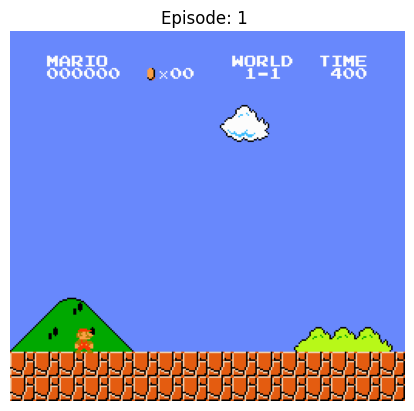

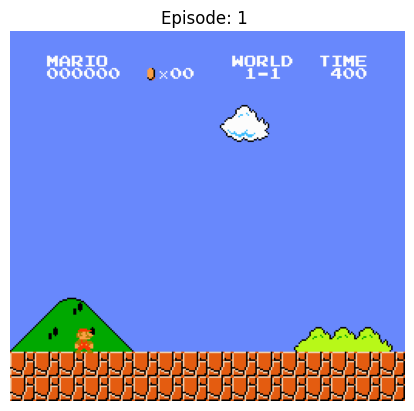

In [8]:
show_state(env, 1)

In [85]:
x = state

big_conv_out = local_net.conv(x).view(x.size()[0], -1)
conv_out = local_net.conv_to_32(big_conv_out)

batched_conv_out = conv_out.reshape(conv_out.shape[0], 1, conv_out.shape[-1]).repeat(1, sampled_actions.shape[-2], 1)

latent_actions = local_net.action_fc(sampled_actions)

batched_actions = torch.cat((batched_conv_out, latent_actions), dim=2)

out =  torch.flatten(local_net.fc(batched_actions), start_dim=1)

In [118]:
torch.mean(out).data.numpy().item()

0.1326681673526764

In [119]:
np.mean([1,2])

1.5